# 2Hop Multiple Choice Answers Questions

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import string
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load the CSV file
df = pd.read_csv('data/2hop_MCQ.csv')  # Replace with your actual CSV file path

# Verify the number of rows
print(f"Loaded {len(df)} questions")

Loaded 500 questions


In [3]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 100)
print(f"{'Question':50} | {'Truth':5} | {'With Ctx':8} | {'Without Ctx':10} | {'Notes'}")
print("-" * 100)

# Count different error types
context_helped_count = 0
context_misled_count = 0
both_incorrect_count = 0
both_correct_count = 0

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Check if either prediction is incorrect (using standardized answers)
    with_context_correct = (with_context == ground_truth) if (with_context is not None and ground_truth is not None) else False
    without_context_correct = (without_context == ground_truth) if (without_context is not None and ground_truth is not None) else False
    
    # Track counts for summary
    if with_context_correct and without_context_correct:
        both_correct_count += 1
    elif with_context_correct and not without_context_correct:
        context_helped_count += 1
    elif not with_context_correct and without_context_correct:
        context_misled_count += 1
    elif not with_context_correct and not without_context_correct:
        both_incorrect_count += 1
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct) and ground_truth is not None:
        # Truncate question for display
        question = row['question'][:47] + "..." if len(row['question']) > 47 else row['question'].ljust(47)
        
        # Format for display
        truth_display = str(ground_truth).ljust(5) if ground_truth else "None".ljust(5)
        with_ctx_display = str(with_context).ljust(8) if with_context else "None".ljust(8)
        without_ctx_display = str(without_context).ljust(10) if without_context else "None".ljust(10)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {truth_display} | {with_ctx_display} | {without_ctx_display} | {notes}")

# Print summary statistics
total_questions = len(df)
answerable_questions = sum(1 for ans in df['standardized_answer'] if ans is not None)

print("\nSummary Statistics:")
print(f"Total questions: {total_questions}")
print(f"Answerable questions (with valid ground truth): {answerable_questions}")
print(f"Both approaches correct: {both_correct_count} ({both_correct_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context helped: {context_helped_count} ({context_helped_count/answerable_questions*100:.1f}% of answerable)")
print(f"Context misled: {context_misled_count} ({context_misled_count/answerable_questions*100:.1f}% of answerable)")
print(f"Both approaches incorrect: {both_incorrect_count} ({both_incorrect_count/answerable_questions*100:.1f}% of answerable)")

# Net impact of context
net_impact = context_helped_count - context_misled_count
print(f"\nNet impact of context: {'+' if net_impact > 0 else ''}{net_impact} questions " +
      f"({net_impact/answerable_questions*100:.1f}% of answerable)")


Error Analysis:
----------------------------------------------------------------------------------------------------
Question                                           | Truth | With Ctx | Without Ctx | Notes
----------------------------------------------------------------------------------------------------
Can dry AMD progress to geographic atrophy due ... | B     | A        | A          | Both incorrect
Does hypertension worsen AMD by elevating choro... | B     | A        | A          | Both incorrect
Does diabetes heighten AMD risk by causing dire... | B     | A        | B          | Context misled
Does a diet rich in leafy greens reduce AMD ris... | B     | B        | A          | Context helped
Can wet AMD cause legal blindness by impairing ... | B     | A        | A          | Both incorrect
Does dry AMD progress slowly because it avoids ... | B     | A        | A          | Both incorrect
Can hypertension exacerbate AMD by causing reti... | B     | A        | A          | Both


Context Impact Summary (excluding unknown):
Positive: 31 questions (6.2%)
Neutral: 370 questions (74.0%)
Negative: 35 questions (7.0%)
No Help: 64 questions (12.8%)

Additionally, there were 0 questions with unknown impact due to missing data.

Net Positive Impact: -4 questions (-0.8% of known impact questions)


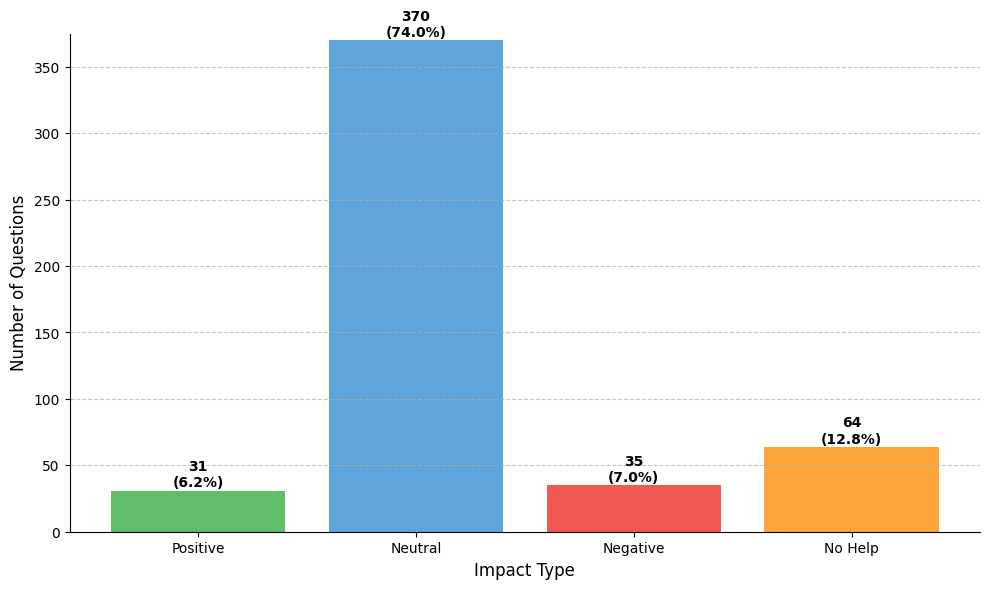


Performance Metrics:
With Context (RAG):
  Accuracy: 0.80
  Precision: 0.78
  Recall: 0.75
  F1 Score: 0.75
Without Context (Simple Model):
  Accuracy: 0.81
  Precision: 0.55
  Recall: 0.54
  F1 Score: 0.54


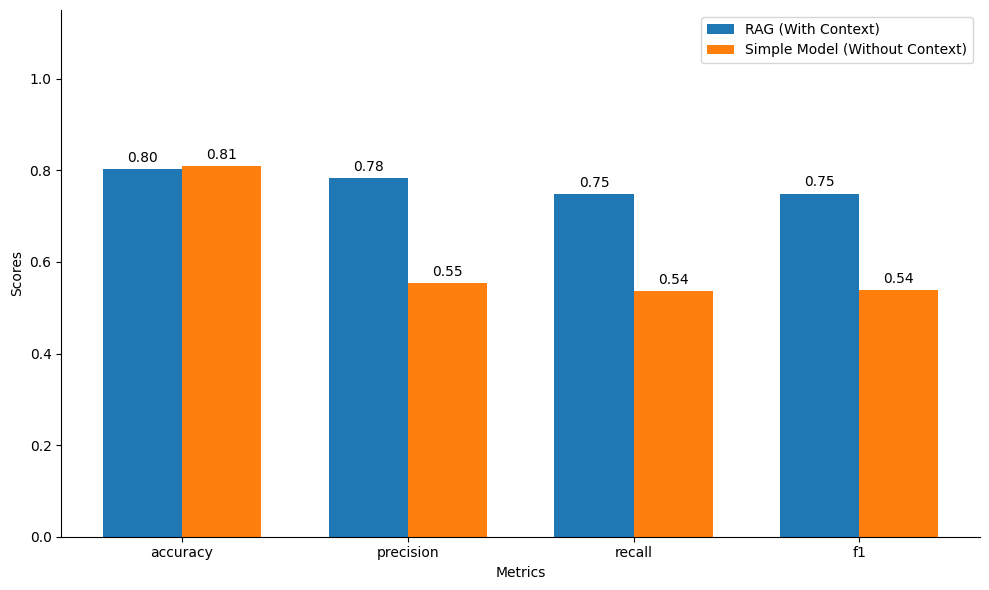

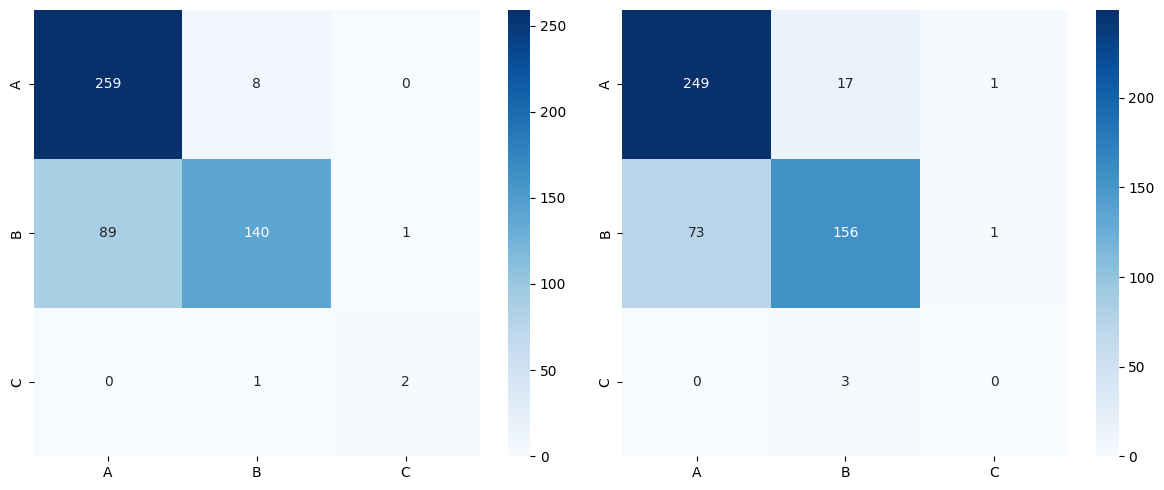

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Analyze the impact of context on each question
df['context_impact'] = None

for i, row in df.iterrows():
    # Get standardized answers for comparison
    ground_truth = row['standardized_answer']
    with_context = row['with_context_parsed']
    without_context = row['without_context_parsed']
    
    # Skip if ground truth or either prediction is None
    if ground_truth is None or with_context is None or without_context is None:
        df.at[i, 'context_impact'] = 'Unknown'
        continue
        
    with_correct = with_context == ground_truth
    without_correct = without_context == ground_truth
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact'].value_counts()
unknown_count = impact_counts.get('Unknown', 0)

# Define the order and colors for consistency
impact_order = ['Positive', 'Neutral', 'Negative', 'No Help']
impact_colors = {
    'Positive': '#60BD68',  # Green
    'Neutral': '#5DA5DA',   # Blue
    'Negative': '#F15854',  # Red
    'No Help': '#FAA43A',   # Orange
}

# Get counts for known impacts
ordered_counts = [impact_counts.get(impact, 0) for impact in impact_order]
total_known = sum(ordered_counts)

# Print summary excluding unknown
print("\nContext Impact Summary (excluding unknown):")
for impact in impact_order:
    count = impact_counts.get(impact, 0)
    percentage = (count / total_known * 100) if total_known > 0 else 0
    print(f"{impact}: {count} questions ({percentage:.1f}%)")

# Print unknown count separately
print(f"\nAdditionally, there were {unknown_count} questions with unknown impact due to missing data.")

# Calculate net positive impact based on known impacts
positive_count = impact_counts.get('Positive', 0)
negative_count = impact_counts.get('Negative', 0)
net_impact = positive_count - negative_count
net_percentage = (net_impact / total_known * 100) if total_known > 0 else 0
print(f"\nNet Positive Impact: {net_impact} questions ({net_percentage:.1f}% of known impact questions)")

# Visualize context impact
plt.figure(figsize=(10, 6))
bars = plt.bar(impact_order, ordered_counts, color=[impact_colors[impact] for impact in impact_order])
plt.xlabel('Impact Type', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count and percentage labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (height / total_known * 100) if total_known > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Set y-axis limit with padding
max_height = max(ordered_counts) if ordered_counts else 0
plt.ylim(0, max_height + 5)

# Hide top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(top=False, right=False)

plt.tight_layout()
plt.savefig('context_impact.png')
plt.show()

# Compute metrics for comparison
valid_df = df.dropna(subset=['standardized_answer', 'with_context_parsed', 'without_context_parsed'])

if not valid_df.empty:
    y_true = valid_df['standardized_answer']
    y_pred_with = valid_df['with_context_parsed']
    y_pred_without = valid_df['without_context_parsed']

    # Compute metrics for with-context (RAG)
    accuracy_with = accuracy_score(y_true, y_pred_with)
    precision_with = precision_score(y_true, y_pred_with, average='macro', zero_division=0)
    recall_with = recall_score(y_true, y_pred_with, average='macro', zero_division=0)
    f1_with = f1_score(y_true, y_pred_with, average='macro', zero_division=0)
    cm_with = confusion_matrix(y_true, y_pred_with)

    # Compute metrics for without-context (Simple Model)
    accuracy_without = accuracy_score(y_true, y_pred_without)
    precision_without = precision_score(y_true, y_pred_without, average='macro', zero_division=0)
    recall_without = recall_score(y_true, y_pred_without, average='macro', zero_division=0)
    f1_without = f1_score(y_true, y_pred_without, average='macro', zero_division=0)
    cm_without = confusion_matrix(y_true, y_pred_without)

    # Print the metrics
    print("\nPerformance Metrics:")
    print("With Context (RAG):")
    print(f"  Accuracy: {accuracy_with:.2f}")
    print(f"  Precision: {precision_with:.2f}")
    print(f"  Recall: {recall_with:.2f}")
    print(f"  F1 Score: {f1_with:.2f}")
    print("Without Context (Simple Model):")
    print(f"  Accuracy: {accuracy_without:.2f}")
    print(f"  Precision: {precision_without:.2f}")
    print(f"  Recall: {recall_without:.2f}")
    print(f"  F1 Score: {f1_without:.2f}")

    # Visualize metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    rag_values = [accuracy_with, precision_with, recall_with, f1_with]
    simple_values = [accuracy_without, precision_without, recall_without, f1_without]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, rag_values, width, label='RAG (With Context)', color='#1f77b4')
    rects2 = ax.bar(x + width/2, simple_values, width, label='Simple Model (Without Context)', color='#ff7f0e')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1.15)

    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=False, right=False)

    plt.tight_layout()
    plt.savefig('metrics_comparison.png')
    plt.show()

    # Visualize confusion matrices
    labels = sorted(set(y_true))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_with, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=labels, yticklabels=labels)
    sns.heatmap(cm_without, annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=labels, yticklabels=labels)

    # Hide top and right spines for both axes
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(top=False, right=False)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()
else:
    print("Not enough data to compute metrics")